This Jupyter Notebook contains all the process to develop a model that can predict the category of tweets related with COVID-19. The category for each tweet can be one or more of the following four categories: Accept, Reject, No Stance, Not Relevant.

# Setup

First of all, we start by importing the necessary libraries.

In [1]:
import pandas as pd
import tweepy
import os
import json
from dotenv import load_dotenv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import wget
import zipfile
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('punkt')
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from keras import backend as K
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joaobrandao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joaobrandao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
load_dotenv()

True

Then, we configure the client variable with a Client instance of the library tweepy, that will allow us to collect the tweets to train and test our model. To configure this Client instance, it's necessary to have a Twitter API Public and Secret Key, as well as a Public and Secret Token. Those Keys and Tokens were configured individually for each group member, based on each one Twitter API credentials, on the .env file, which contains only the structure with placeholders at the delivery stage. In order to run the code from now on, it's necessary to configure properly the .env file first.  

In [3]:
API_KEY = os.environ.get("API_KEY")
API_SECRET_KEY = os.environ.get("API_SECRET_KEY")
ACCESS_TOKEN = os.environ.get("ACCESS_TOKEN")
ACCESS_TOKEN_SECRET = os.environ.get("ACCESS_TOKEN_SECRET")
FILE_PATH = os.environ.get("FILE_PATH")

client = tweepy.Client(
    consumer_key=API_KEY,
    consumer_secret=API_SECRET_KEY,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET
)

# Building Dataframes

Having the tweepy configured properly, we can now start building the working dataframes before we move on to the data preparation and to the following stages. From now on, all the procedures applied to the train data will also be applied to the test data, which means we'll just refer to them as procedures on the data as a whole.

The following code snippets loads the data from the train and test JSON files into lists, one that holds the tweets ids and the corresponding categories and the other one just the tweets ids.

In [4]:
with open(FILE_PATH + 'train.jsonl', 'r') as json_file:
    json_train = list(json_file)

with open(FILE_PATH + 'test.jsonl', 'r') as json_file:
    json_test = list(json_file)

In [5]:
def get_category(categories):
    if categories['Reject'] > 0:
        return 'Reject'
    elif categories['Accept'] > 0:
        return 'Accept'
    elif categories['Not Relevant'] >= categories['No Stance']:
        return 'Not Relevant'
    else:
        return 'No Stance'

In [6]:
train_ids = []
categories_train = []
for json_str in json_train:
    categories = {"Accept":0, "Reject":0, "No Stance":0, "Not Relevant":0}
    dataset_ids = json.loads(json_str)
    for key, value in dataset_ids['misinfo'].items():
        categories[value] = categories[value] + 1
    train_ids.append(dataset_ids['id'])
    categories_train.append([dataset_ids['id'], get_category(categories)])

test_ids = []
categories_test = []
for json_str in json_test:
    categories = {"Accept":0, "Reject":0, "No Stance":0, "Not Relevant":0}
    dataset_ids = json.loads(json_str)
    for key, value in dataset_ids['misinfo'].items():
        categories[value] = categories[value] + 1
    test_ids.append(dataset_ids['id'])
    categories_test.append([dataset_ids['id'], get_category(categories)])

In [7]:
test_ids = [test_ids[i: i + 100] for i in range(0, len(test_ids), 100)]

train_ids = [train_ids[i: i + 100] for i in range(0, len(train_ids), 100)]

The following code uses the function ```get_tweets``` from tweepy to get the tweets content by id, from the JSON files, retrieving also the name, username, user id and the flag verified (true if the author of the tweet has the account verified by Twitter) associated with each tweet. The information regarding the tweets content is stored in a separate list from the one containing the users information.

In [8]:
responses_ts_train = []
for tweet_id in train_ids:
    tweets = client.get_tweets(ids=tweet_id, user_auth=True, tweet_fields=['created_at'])
    for tweet in tweets[0]:
        responses_ts_train.append([tweet.id, tweet.text, tweet.created_at])

In [9]:
responses_ts_test = []
for tweet_id in test_ids:
    tweets = client.get_tweets(ids=tweet_id, user_auth=True, tweet_fields=['created_at'])
    for tweet in tweets[0]:
        responses_ts_test.append([tweet.id, tweet.text, tweet.created_at])

In [10]:
responses_train = []
users_train = []
for tweet_id in train_ids:
    tweets = client.get_tweets(ids=tweet_id, user_auth=True, user_fields=['name', 'username', 'verified', 'id'], expansions="author_id")
    for tweet in tweets[0]:
        responses_train.append([tweet.id, tweet.text, tweet.author_id])
    for user in tweets[1]['users']:
        users_train.append([user.id, user.name, user.username, user.verified])

In [11]:
responses_test = []
users_test = []
for tweet_id in test_ids:
    tweets = client.get_tweets(ids=tweet_id, user_auth=True, user_fields=['name', 'username', 'verified', 'id'], expansions="author_id")
    for tweet in tweets[0]:
        responses_test.append([tweet.id, tweet.text, tweet.author_id])
    for user in tweets[1]['users']:
        users_test.append([user.id, user.name, user.username, user.verified])

## TIME SERIES DATA

In [12]:
ts_data = pd.read_csv('../datasets/country_vaccinations.csv')

In [13]:
ts_data.drop(columns=['total_vaccinations','daily_vaccinations_raw','people_vaccinated','people_fully_vaccinated','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','total_vaccinations_per_hundred','vaccines','source_name','source_website'], inplace=True)

In [14]:
ts_data.dropna(subset=['daily_vaccinations'], axis=0, inplace=True)

In [15]:
ts_data['date'] = pd.to_datetime(ts_data['date'])

In [16]:
ts_data['date'] = ts_data['date'].dt.date

Then, the three lists previously created, one for the tweets content, another for the users and another for the categories are converted into dataframes and merged right after through the common attributes. A conversion of the common columns was made to avoid problems of type incompatibility at a later stage (i.e. on the merge).

In [17]:
responses_train = pd.DataFrame(responses_train, columns = ['TweetID', 'Tweet', 'AuthorID'])
responses_test = pd.DataFrame(responses_test, columns = ['TweetID', 'Tweet', 'AuthorID'])

users_train = pd.DataFrame(users_train, columns = ['AuthorID', 'Name', 'Username', 'Verified'])
users_test = pd.DataFrame(users_test, columns = ['AuthorID', 'Name', 'Username', 'Verified'])

categories_train = pd.DataFrame(categories_train, columns = ['TweetID', 'Category'])
categories_test = pd.DataFrame(categories_test, columns = ['TweetID', 'Category'])

ts_train = pd.DataFrame(responses_ts_train, columns = ['TweetID', 'Tweet', 'Date'])
ts_test = pd.DataFrame(responses_ts_test, columns = ['TweetID', 'Tweet', 'Date'])

In [18]:
responses_train['TweetID'] = responses_train['TweetID'].astype(str)
responses_test['TweetID'] = responses_test['TweetID'].astype(str)
responses_train['AuthorID'] = responses_train['AuthorID'].astype(str)
responses_test['AuthorID'] = responses_test['AuthorID'].astype(str)

users_train['AuthorID'] = users_train['AuthorID'].astype(str)
users_test['AuthorID'] = users_test['AuthorID'].astype(str)

categories_train['TweetID'] = categories_train['TweetID'].astype(str)
categories_test['TweetID'] = categories_test['TweetID'].astype(str)

ts_train['TweetID'] = ts_train['TweetID'].astype(str)
ts_test['TweetID'] = ts_test['TweetID'].astype(str)

In [19]:
df_train = pd.merge(responses_train, users_train, on='AuthorID', how='outer')
df_train = pd.merge(df_train, categories_train, on='TweetID', how='outer')

df_test = pd.merge(responses_test, users_test, on='AuthorID', how='outer')
df_test = pd.merge(df_test, categories_test, on='TweetID', how='outer')

ts_final_train = pd.merge(ts_train, categories_train, on='TweetID', how='outer')
ts_final_test = pd.merge(ts_test, categories_test, on='TweetID', how='outer')

In [20]:
ts_final_train['Date'] = pd.to_datetime(ts_final_train['Date']).dt.date

In [21]:
ts_final_test['Date'] = pd.to_datetime(ts_final_test['Date']).dt.date

In [22]:
ts_final_train.dropna(subset=['Tweet'], axis=0, inplace=True)

In [23]:
ts_final_test.dropna(subset=['Tweet'], axis=0, inplace=True)

In [24]:
ts_final_train.drop(columns=['TweetID', 'Tweet'], inplace=True)

In [25]:
ts_final_test.drop(columns=['TweetID', 'Tweet'], inplace=True)

In [26]:
ts_final_train.sort_values(by='Date', inplace=True)

In [27]:
ts_final_test.sort_values(by='Date', inplace=True)

In [28]:
ts_data = ts_data.loc[(ts_data['date'] >= ts_final_train['Date'].min()) & (ts_data['date'] <= ts_final_train['Date'].max())]

In [29]:
ts_data.sort_values(by='date', inplace=True)

In [30]:
ts_data.rename(columns={'date': 'Date'}, inplace=True)

In [31]:
ts_data.drop(columns=['country','iso_code','daily_vaccinations'],inplace=True)

In [32]:
def sumTotal(lista):
    accept = 0
    reject = 0
    total = 0
    new_list_accepts = []
    new_list_rejects = []
    aux = lista[0][0]
    for i in lista:
        if i[0] == aux:
            if i[1] == 'Accept':
                accept = accept + 1
                total = total + 1
            elif i[1] == 'Reject':
                reject = reject + 1
                total = total + 1
            else:
                total = total + 1
                pass
        else:
            new_list_accepts.append([aux, accept/total * 100])
            new_list_rejects.append([aux, reject/total * 100])
            accept = 0
            reject = 0
            total = 0
            aux = i[0]
            if i[1] == 'Accept':
                accept = accept + 1
                total = total + 1
            elif i[1] == 'Reject':
                reject = reject + 1
                total = total + 1
            else:
                total = total + 1
                pass

    new_list_accepts.append([aux, accept/total * 100])
    new_list_rejects.append([aux, reject/total * 100])

    return new_list_accepts, new_list_rejects

In [33]:
def sumVaccinations(lista):
    total = 0;
    aux = lista[0][0]
    total_lista = []
    for l in lista:
        if l[0] == aux:
            total = total + l[1]
        else:
            total_lista.append([aux, total])
            total = 0
            aux = l[0]

    total_lista.append([aux, total])

    return total_lista

In [34]:
accept_train,reject_train = sumTotal(ts_final_train.values.tolist())

In [35]:
accept_test,reject_test = sumTotal(ts_final_test.values.tolist())

In [36]:
accept_train_final = pd.DataFrame(accept_train, columns = ['Date', 'Accept'])

In [37]:
reject_train_final = pd.DataFrame(reject_train, columns = ['Date', 'Reject'])

In [38]:
accept_test_final = pd.DataFrame(accept_test, columns = ['Date', 'Accept'])

In [39]:
reject_test_final = pd.DataFrame(reject_test, columns = ['Date', 'Reject'])

In [40]:
ts_train_final = pd.merge(accept_train_final, reject_train_final, on='Date', how='outer')

In [41]:
ts_test_final = pd.merge(accept_test_final, reject_test_final, on='Date', how='outer')

In [42]:
ts_data_list = sumVaccinations(ts_data.values.tolist())

In [43]:
ts_data_list = pd.DataFrame(ts_data_list, columns=['Date', 'Daily Vaccinations'])

In [44]:
train_final = pd.merge(ts_train_final, ts_data_list, on='Date', how='outer')

In [45]:
train_final.dropna(subset='Accept',axis=0, inplace=True)

In [46]:
train_final['Date'] = pd.to_datetime(train_final['Date'])

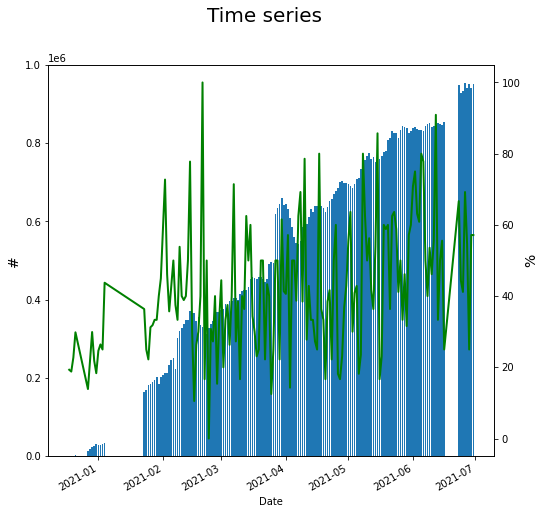

In [47]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.bar(train_final['Date'], train_final['Daily Vaccinations'])
ax2.plot(train_final['Date'], train_final['Accept'], "g", lw=2, label='Accept')

ax1.set_xlabel("Date")
ax1.set_ylabel("#", fontsize=14)

ax2.set_ylabel("%", fontsize=14)

fig.autofmt_xdate()
fig.suptitle("Time series", fontsize=20);

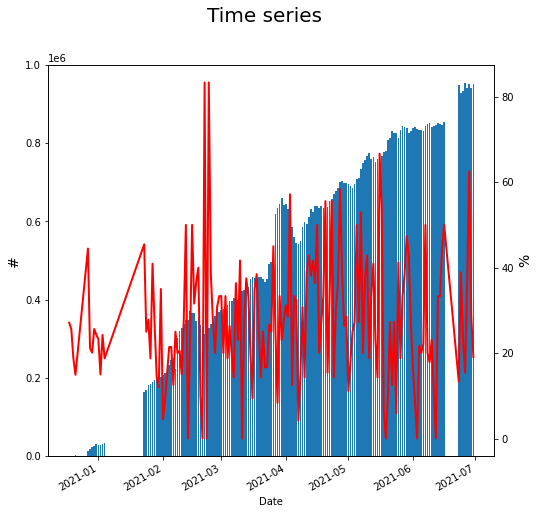

In [48]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.bar(train_final['Date'], train_final['Daily Vaccinations'])
ax2.plot(train_final['Date'], train_final['Reject'], "r-" ,lw=2, label='Reject')

ax1.set_xlabel("Date")
ax1.set_ylabel("#", fontsize=14)

ax2.set_ylabel("%", fontsize=14)

fig.autofmt_xdate()
fig.suptitle("Time series", fontsize=20);

In [49]:
test_final = pd.merge(ts_test_final, ts_data_list, on='Date', how='outer')

In [50]:
test_final.dropna(subset='Accept',axis=0, inplace=True)

In [51]:
test_final['Date'] = pd.to_datetime(test_final['Date'])

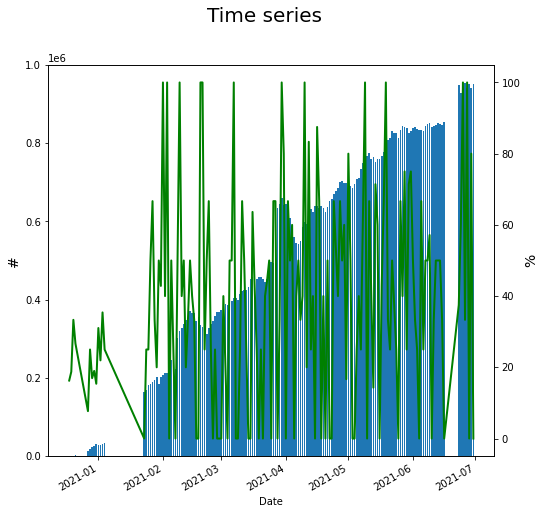

In [52]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.bar(train_final['Date'], train_final['Daily Vaccinations'])
ax2.plot(test_final['Date'], test_final['Accept'], "g",lw=2, label='Accept')

ax1.set_xlabel("Date")
ax1.set_ylabel("#", fontsize=14)

ax2.set_ylabel("%", fontsize=14)

fig.autofmt_xdate()
fig.suptitle("Time series", fontsize=20);

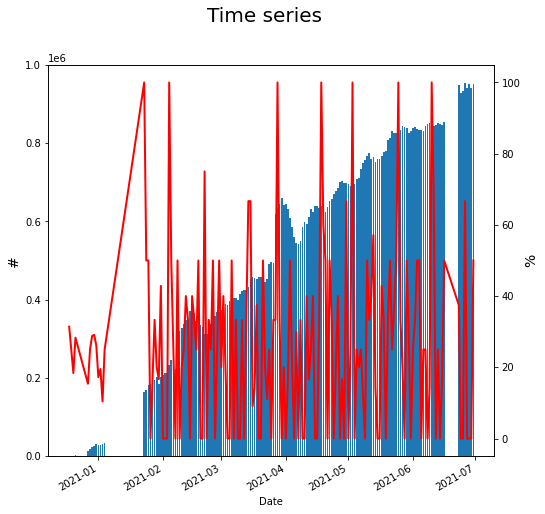

In [53]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.bar(train_final['Date'], train_final['Daily Vaccinations'])
ax2.plot(test_final['Date'], test_final['Reject'], "r-", lw=2, label='Reject')

ax1.set_xlabel("Date")
ax1.set_ylabel("#", fontsize=14)

ax2.set_ylabel("%", fontsize=14)

fig.autofmt_xdate()
fig.suptitle("Time series", fontsize=20);

Before we drop the TweetID column, we check how many unique tweets we have in each dataframe.

In [54]:
df_train['TweetID'].is_unique

False

In [55]:
df_test['TweetID'].is_unique

False

Having know only two dataframes, one for test and another one for train, we drop the useless columns with the IDs of the Tweets and the Authors of them.

In [56]:
df_train = df_train.drop(columns=['TweetID', 'AuthorID'], axis=1)
df_test = df_test.drop(columns=['TweetID', 'AuthorID'], axis=1)

This is the final version of the dataframes for train and test before the data analysis phase.

In [57]:
df_train.head()

,Tweet,Name,Username,Verified,Category
0,@nytimes There are side effects of this inject...,mary podlesak,MaryPodlesak,False,No Stance
1,@nytimes There are side effects of this inject...,mary podlesak,MaryPodlesak,False,No Stance
2,Religious Exemption to the Covid 19 vaccine ma...,mary podlesak,MaryPodlesak,False,No Stance
3,Religious Exemption to the Covid 19 vaccine ma...,mary podlesak,MaryPodlesak,False,No Stance
4,Moderna seeks FDA emergency use authorization ...,isirv antiviral,isirvAVG,False,Reject


In [58]:
df_test.head()

,Tweet,Name,Username,Verified,Category
0,@donutsdebsdibs @VFreedoms The fact that 99.99...,"Anyway, moving on..",anywaymovingon,False,Accept
1,@OceanEyes50 I have a 99.55% chance of survivi...,🇺🇸David Son of Liberty🇺🇸,DavidLiberty76,False,Accept
2,While getting COVID-19 may offer some natural ...,USA Healthcare,USAHealthcareAL,False,No Stance
3,Has @ArvindKejriwal entered into Contract to b...,Pawan Kumar Aggarwal,aggarwal1953,False,Not Relevant
4,News: Statement from NIH and BARDA on the FDA ...,NIH,NIH,True,No Stance


# Data Preparation

To start the data preparation phase, we drop the duplicates from both datasets.

In [59]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

## Word embeddings

GloVe (Global Vectors - Stanford University)

Pretrained 300-dimensional GloVe embeddings trained on Wikipedia 2014 and Gigaword 5

Source: https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

In [60]:
# Download glove and unzip it in Notebook.
if not os.path.exists('glove.6B.zip'):
    filename = wget.download('http://nlp.stanford.edu/data/glove.6B.zip')
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(".")

In [61]:
# Embedding: 1->dense vector
def embedding_for_vocab(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
      
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab

In [62]:
def create_dict(column1, column2):
    tweets = column1.astype(str).to_list() + column2.astype(str).to_list()

    # Dictionary creation
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets)

    return tokenizer

In [63]:
def get_embeddings(column, tokenizer):    
    # Getting the number of unique words in the dictionary
    #print("Number of unique words in dictionary=", len(tokenizer.word_index))
    #print("Dictionary is = ", tokenizer.word_index)

    # Matrix for vocab: word_index
    embedding_dim = 300
    embedding_matrix_vocab = embedding_for_vocab('./glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

    new_column = []
    for entry in column:
        entry = str(entry).split(' ')
        new_entry = []
        for word in entry:
            if str(word) in tokenizer.word_index:
                new_entry.append(sum(embedding_matrix_vocab[tokenizer.word_index[str(word)]]))
            else: # Non-existent word in dictionary
                new_entry.append(sum(embedding_matrix_vocab[0]))
        new_column.append(new_entry)

    return new_column

## Regular expression-based removal of special characters

In [64]:
def re_removal(column):
    re_removal_list = []
    for entry in column:
        cleaned = re.sub("[^a-zA-Z0-9']"," ",entry)
        lowered = cleaned.lower()
        re_removal_list.append(lowered.strip())
    return re_removal_list

## Categorical to Numerical

In [65]:
def categorial_to_numerical(column):
    return pd.factorize(column)[0]

## NLTK Stop Words

In [66]:
def remove_stopwords(column):
    stopWords = set(stopwords.words('english'))
    new_column = []
    for value in column:
        entry = ''
        value = value.split(' ')
        for word in value:
            if word not in stopWords:
                entry += word + " "
        new_column.append(entry)
    return new_column

## List column to multiple columns

In [67]:
def multiple_columns(train_df, test_df):
    max_train_tweet = 0
    for tweet in train_df['Tweet']:
        if len(tweet) > max_train_tweet:
            max_train_tweet = len(tweet)

    max_test_tweet = 0
    for tweet in test_df['Tweet']:
        if len(tweet) > max_test_tweet:
            max_test_tweet = len(tweet)
    '''
    max_train_user = 0
    for user in train_df['Name']:
        if len(user) > max_train_user:
            max_train_user = len(user)

    max_test_user = 0
    for user in test_df['Name']:
        if len(user) > max_test_user:
            max_test_user = len(user)
    '''

    len_train = len(df_train)
    len_test = len(df_test)
    
    # train_df
    verified_category = train_df.drop(columns=['Tweet', 'Name', 'Username', 'Category'], axis=1)

    tweet_df = pd.DataFrame(train_df['Tweet'].values.tolist()).add_prefix('tweet')
    #name_df = pd.DataFrame(train_df['Name'].values.tolist()).add_prefix('name')
    #username_df = pd.DataFrame(train_df['Username'].values.tolist()).add_prefix('username')

    tweet_df = tweet_df.fillna(0)
    #name_df = name_df.fillna(0)
    #username_df = username_df.fillna(0)

    verified_category['Verified'] = verified_category['Verified'].astype('float64')

    train_df = verified_category.join(tweet_df).fillna(0)

    # test_df
    verified_category = test_df.drop(columns=['Tweet', 'Name', 'Username', 'Category'], axis=1)

    tweet_df = pd.DataFrame(test_df['Tweet'].values.tolist()).add_prefix('tweet')
    #name_df = pd.DataFrame(test_df['Name'].values.tolist()).add_prefix('name')
    #username_df = pd.DataFrame(test_df['Username'].values.tolist()).add_prefix('username')

    tweet_df = tweet_df.fillna(0)
    #name_df = name_df.fillna(0)
    #username_df = username_df.fillna(0)

    verified_category['Verified'] = verified_category['Verified'].astype('float64')

    test_df = verified_category.join(tweet_df).fillna(0)

    # add extra columns
    if max_test_tweet == max_train_tweet:
        pass
    elif max_test_tweet > max_train_tweet:
        diff = max_test_tweet-max_train_tweet
        for i in range (0, diff):
            colname = 'tweet' + str(max_train_tweet + i)
            train_df[colname] = [0] * len_train
    else:
        diff = max_train_tweet-max_test_tweet
        for i in range (0, diff):
            colname = 'tweet' + str(max_test_tweet + i)
            test_df[colname] = [0] * len_test
    '''
    if max_test_user == max_train_user:
        pass
    elif max_test_user > max_train_user:
        diff = max_test_user-max_train_user
        for i in range (0, diff):
            colname = 'name' + str(max_train_user + i)
            train_df[colname] = [0] * len_train
    else:
        diff = max_train_user-max_test_user
        for i in range (0, diff):
            colname = 'name' + str(max_test_user + i)
            test_df[colname] = [0] * len_test
    '''
    train_df = train_df.reindex(sorted(train_df.columns), axis=1)
    test_df = test_df.reindex(sorted(test_df.columns), axis=1)

    return train_df, test_df

In [68]:
def sum_cols(train_df, test_df):
    i = 0
    for col in train_df:
        if 'tweet' in col:
            if i == 0:
                i+=1
                new_col = train_df[col].values
            else:
                new_col += train_df[col].values
            train_df = train_df.drop(columns=[col], axis=1)
    train_df['tweet'] = new_col

    i = 0
    for col in test_df:
        if 'tweet' in col:
            if i == 0:
                i+=1
                new_col = test_df[col].values
            else:
                new_col += test_df[col].values
            test_df = test_df.drop(columns=[col], axis=1)
    test_df['tweet'] = new_col

    return train_df, test_df

# Data Analysis

After the merge, we print the information regarding how many null entries we still have (if any) and the column types, as well as the distribution of the Verified column values.

In [69]:
f'Number of null values in the train dataframe: {df_train.isnull().sum()}'
f'Number of null values in the test dataframe: {df_test.isnull().sum()}'

'Number of null values in the test dataframe: Tweet       4\nName        4\nUsername    4\nVerified    4\nCategory    0\ndtype: int64'

In [70]:
df_train.dtypes

Tweet       object
Name        object
Username    object
Verified    object
Category    object
dtype: object

In [71]:
df_test.dtypes

Tweet       object
Name        object
Username    object
Verified    object
Category    object
dtype: object

In [72]:
df_train['Verified'].value_counts()

False    4325
True      357
Name: Verified, dtype: int64

In [73]:
df_test['Verified'].value_counts()

False    1202
True       96
Name: Verified, dtype: int64

## Frequent Words

Most Frequent Word Occurrences after removing stop words

In [74]:
Counter(" ".join(remove_stopwords(df_train['Tweet'].astype(str))).split()).most_common(14)

[('vaccine', 2984),
 ('COVID-19', 1640),
 ('The', 903),
 ('people', 702),
 ('Covid-19', 558),
 ('vaccine.', 551),
 ('Covid', 523),
 ('Vaccine', 497),
 ('I', 497),
 ('covid', 489),
 ('get', 428),
 ('vaccines', 425),
 ('COVID', 422),
 ('immune', 394)]

In [75]:
Counter(" ".join(remove_stopwords(df_test['Tweet'].astype(str))).split()).most_common(14)

[('vaccine', 842),
 ('COVID-19', 460),
 ('The', 266),
 ('people', 196),
 ('Covid-19', 158),
 ('covid', 142),
 ('get', 135),
 ('vaccine.', 131),
 ('Vaccine', 129),
 ('immune', 125),
 ('vaccines', 125),
 ('Covid', 125),
 ('I', 124),
 ('COVID', 110)]

## Word Count

Word Count for tweets after removing stop words

In [76]:
tweets = remove_stopwords(df_train['Tweet'].astype(str))
sum_words = 0
num = len(df_train['Tweet'])
for tweet in tweets:
    tweet = tweet.split(' ')
    sum_words += len(tweet)
print(sum_words/num)

18.027102005975244


In [77]:
tweets = remove_stopwords(df_test['Tweet'].astype(str))
sum_words = 0
num = len(df_test['Tweet'])
for tweet in tweets:
    tweet = tweet.split(' ')
    sum_words += len(tweet)
print(sum_words/num)


18.00384024577573


## Tweets with COVID related terms

Percentage of tweets with COVID (or COVID-19 or any other group of words) in total

In [78]:
tweets = df_train['Tweet'].astype(str)
sum_covid = 0
sum_vaccine = 0
num = len(df_train['Tweet'])
for tweet in tweets:
    if 'covid' in tweet.lower() or 'covid-19' in tweet.lower():
        sum_covid += 1
    if 'vaccine' in tweet.lower():
        sum_vaccine += 1
print("Number of Tweets with covid/covid-19 words: " + str(sum_covid) + "/" + str(num) + " (" + str((sum_covid/num)*100) + "%)")
print("Number of Tweets with vaccine words: " + str(sum_vaccine) + "/" + str(num) + " (" + str((sum_vaccine/num)*100) + "%)")

Number of Tweets with covid/covid-19 words: 4017/4686 (85.72343149807938%)
Number of Tweets with vaccine words: 4373/4686 (93.3205292360222%)


In [79]:
tweets = df_test['Tweet'].astype(str)
sum_covid = 0
sum_vaccine = 0
num = len(df_test['Tweet'])
for tweet in tweets:
    if 'covid' in tweet.lower() or 'covid-19' in tweet.lower():
        sum_covid += 1
    if 'vaccine' in tweet.lower():
        sum_vaccine += 1
print("Number of Tweets with covid/covid-19 words: " + str(sum_covid) + "/" + str(num) + " (" + str((sum_covid/num)*100) + "%)")
print("Number of Tweets with vaccine words: " + str(sum_vaccine) + "/" + str(num) + " (" + str((sum_vaccine/num)*100) + "%)")

Number of Tweets with covid/covid-19 words: 1095/1302 (84.10138248847926%)
Number of Tweets with vaccine words: 1191/1302 (91.47465437788019%)


# Models

## Linear SVM Model

In [80]:
svm_df_train = df_train.copy()
svm_df_test = df_test.copy()

In [81]:
svm_df_train['Tweet'] = re_removal(svm_df_train['Tweet'].astype(str))
svm_df_test['Tweet'] = re_removal(svm_df_test['Tweet'].astype(str))

In [82]:
svm_df_train['Tweet'] = remove_stopwords(svm_df_train['Tweet'].astype(str))
svm_df_test['Tweet'] = remove_stopwords(svm_df_test['Tweet'].astype(str))

In [83]:
dictionary_svm = create_dict(svm_df_train['Tweet'], svm_df_test['Tweet'])

In [84]:
svm_df_train['Tweet'] = get_embeddings(svm_df_train['Tweet'], dictionary_svm)
svm_df_test['Tweet'] = get_embeddings(svm_df_test['Tweet'], dictionary_svm)

In [ ]:
svm_df_train['Name'] = get_embeddings(svm_df_train['Name'], dictionary_svm)
svm_df_test['Name'] = get_embeddings(svm_df_test['Name'], dictionary_svm)

In [ ]:
svm_df_train['Username'] = get_embeddings(svm_df_train['Username'], dictionary_svm)
svm_df_test['Username'] = get_embeddings(svm_df_test['Username'], dictionary_svm)

In [ ]:
svm_df_train['Category'] = categorial_to_numerical(svm_df_train['Category'])
svm_df_test['Category'] = categorial_to_numerical(svm_df_test['Category'])

In [ ]:
svm_df_train['Verified'] = categorial_to_numerical(svm_df_train['Verified'])
svm_df_test['Verified'] = categorial_to_numerical(svm_df_test['Verified'])

In [ ]:
svm_df_train.head()

In [ ]:
svm_df_test.head()

In [ ]:
svm_model = svm.LinearSVC(dual=False)

**Note:** dual=False since n_samples > n_features

In [ ]:
y_svm = svm_df_train['Category']
y_test_svm = svm_df_test['Category']
X_svm, X_test_svm = multiple_columns(svm_df_train, svm_df_test)

In [ ]:
svm_model.fit(X_svm,y_svm)

In [ ]:
svm_predicted = svm_model.predict(X_test_svm)

In [ ]:
f1score_svm_macro = f1_score(y_test_svm, svm_predicted, average='macro')
print("Linear SVM Model - Macro F1 Score: " + str(f1score_svm_macro*100) + "%")

In [ ]:
f1score_svm_weighted = f1_score(y_test_svm, svm_predicted, average='weighted')
print("Linear SVM Model - Weighted F1 Score: " + str(f1score_svm_weighted*100) + "%")

In [ ]:
print(y_svm)
print(y_test_svm)
print(X_svm)
print(X_test_svm)
print(svm_predicted)
print(f1score_svm_macro)
print(f1score_svm_weighted)

## Logistic Regression Model

In [ ]:
lrm_df_train = df_train.copy()
lrm_df_test = df_test.copy()

In [ ]:
lrm_df_train['Tweet'] = re_removal(lrm_df_train['Tweet'].astype(str))
lrm_df_test['Tweet'] = re_removal(lrm_df_test['Tweet'].astype(str))

In [ ]:
lrm_df_train['Tweet'] = remove_stopwords(lrm_df_train['Tweet'].astype(str))
lrm_df_test['Tweet'] = remove_stopwords(lrm_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(lrm_df_train['Tweet'], lrm_df_test['Tweet'])

In [ ]:
lrm_df_train['Tweet'] = get_embeddings(lrm_df_train['Tweet'], dictionary)
lrm_df_test['Tweet'] = get_embeddings(lrm_df_test['Tweet'], dictionary)

In [ ]:
lrm_df_train['Name'] = get_embeddings(lrm_df_train['Name'], dictionary)
lrm_df_test['Name'] = get_embeddings(lrm_df_test['Name'], dictionary)

In [ ]:
lrm_df_train['Username'] = get_embeddings(lrm_df_train['Username'], dictionary)
lrm_df_test['Username'] = get_embeddings(lrm_df_test['Username'], dictionary)

In [ ]:
lrm_df_train['Category'] = categorial_to_numerical(lrm_df_train['Category'])
lrm_df_test['Category'] = categorial_to_numerical(lrm_df_test['Category'])

In [ ]:
lrm_df_train['Verified'] = categorial_to_numerical(lrm_df_train['Verified'])
lrm_df_test['Verified'] = categorial_to_numerical(lrm_df_test['Verified'])

In [ ]:
lrm_model = LogisticRegression(solver='liblinear')

In [ ]:
y_lrm = lrm_df_train['Category']
y_test_lrm = lrm_df_test['Category']
X_lrm, X_test_lrm = multiple_columns(lrm_df_train, lrm_df_test)

In [ ]:
lrm_model.fit(X_lrm,y_lrm)

In [ ]:
lrm_predicted = lrm_model.predict(X_test_lrm)

In [ ]:
f1score_lrm_macro = f1_score(y_test_lrm, lrm_predicted, average='macro')
print("Logistic Regression Model - Macro F1 Score: " + str(f1score_lrm_macro*100) + "%")

In [ ]:
f1score_lrm_weighted = f1_score(y_test_lrm, lrm_predicted, average='weighted')
print("Logistic Regression Model - Weighted F1 Score: " + str(f1score_lrm_weighted*100) + "%")

In [ ]:
print(y_lrm)
print(y_test_lrm)
print(X_lrm)
print(X_test_lrm)
print(lrm_predicted)
print(f1score_lrm_macro)
print(f1score_lrm_weighted)

## Random Forest Model

In [ ]:
rfm_df_train = df_train
rfm_df_test = df_test

In [ ]:
rfm_df_train['Tweet'] = re_removal(rfm_df_train['Tweet'].astype(str))
rfm_df_test['Tweet'] = re_removal(rfm_df_test['Tweet'].astype(str))

In [ ]:
rfm_df_train['Tweet'] = remove_stopwords(rfm_df_train['Tweet'].astype(str))
rfm_df_test['Tweet'] = remove_stopwords(rfm_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(rfm_df_train['Tweet'], rfm_df_test['Tweet'])

In [ ]:
rfm_df_train['Tweet'] = get_embeddings(rfm_df_train['Tweet'], dictionary)
rfm_df_test['Tweet'] = get_embeddings(rfm_df_test['Tweet'], dictionary)

In [ ]:
rfm_df_train['Name'] = get_embeddings(rfm_df_train['Name'], dictionary)
rfm_df_test['Name'] = get_embeddings(rfm_df_test['Name'], dictionary)

In [ ]:
rfm_df_train['Username'] = get_embeddings(rfm_df_train['Username'], dictionary)
rfm_df_test['Username'] = get_embeddings(rfm_df_test['Username'], dictionary)

In [ ]:
rfm_df_train['Category'] = categorial_to_numerical(rfm_df_train['Category'])
rfm_df_test['Category'] = categorial_to_numerical(rfm_df_test['Category'])

In [ ]:
rfm_df_train['Verified'] = categorial_to_numerical(rfm_df_train['Verified'])
rfm_df_test['Verified'] = categorial_to_numerical(rfm_df_test['Verified'])

In [ ]:
rfm_model = RandomForestClassifier()

In [ ]:
y = rfm_df_train['Category']
y_test = rfm_df_test['Category']
X, X_test = multiple_columns(rfm_df_train, rfm_df_test)

In [ ]:
rfm_model.fit(X, y)

In [ ]:
rfm_predicted = rfm_model.predict(X_test)

In [ ]:
f1score = f1_score(y_test, rfm_predicted, average='macro')
print("Random Forest Model - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, rfm_predicted, average='weighted')
print("Random Forest Model - Weighted F1 Score: " + str(f1score*100) + "%")

## Naive Bayes Model

In [ ]:
nbm_df_train = df_train
nbm_df_test = df_test

In [ ]:
nbm_df_train['Tweet'] = re_removal(nbm_df_train['Tweet'].astype(str))
nbm_df_test['Tweet'] = re_removal(nbm_df_test['Tweet'].astype(str))

In [ ]:
nbm_df_train['Tweet'] = remove_stopwords(nbm_df_train['Tweet'].astype(str))
nbm_df_test['Tweet'] = remove_stopwords(nbm_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(nbm_df_train['Tweet'], nbm_df_test['Tweet'])

In [ ]:
nbm_df_train['Tweet'] = get_embeddings(nbm_df_train['Tweet'], dictionary)
nbm_df_test['Tweet'] = get_embeddings(nbm_df_test['Tweet'], dictionary)

In [ ]:
nbm_df_train['Name'] = get_embeddings(nbm_df_train['Name'], dictionary)
nbm_df_test['Name'] = get_embeddings(nbm_df_test['Name'], dictionary)

In [ ]:
nbm_df_train['Username'] = get_embeddings(nbm_df_train['Username'], dictionary)
nbm_df_test['Username'] = get_embeddings(nbm_df_test['Username'], dictionary)

In [ ]:
nbm_df_train['Category'] = categorial_to_numerical(nbm_df_train['Category'])
nbm_df_test['Category'] = categorial_to_numerical(nbm_df_test['Category'])

In [ ]:
nbm_df_train['Verified'] = categorial_to_numerical(nbm_df_train['Verified'])
nbm_df_test['Verified'] = categorial_to_numerical(nbm_df_test['Verified'])

In [ ]:
nbm_model = GaussianNB()

In [ ]:
y = nbm_df_train['Category']
y_test = nbm_df_test['Category']
X, X_test = multiple_columns(nbm_df_train, nbm_df_test)

In [ ]:
nbm_model.fit(X, y)

In [ ]:
nbm_predicted = nbm_model.predict(X_test)

In [ ]:
f1score = f1_score(y_test, nbm_predicted, average='macro')
print("Naive Bayes Model - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, nbm_predicted, average='weighted')
print("Naive Bayes Model - Weighted F1 Score: " + str(f1score*100) + "%")

## K-Nearest Neighbor Model

In [ ]:
knnm_df_train = df_train
knnm_df_test = df_test

In [ ]:
knnm_df_train['Tweet'] = re_removal(knnm_df_train['Tweet'].astype(str))
knnm_df_test['Tweet'] = re_removal(knnm_df_test['Tweet'].astype(str))

In [ ]:
knnm_df_train['Tweet'] = remove_stopwords(knnm_df_train['Tweet'].astype(str))
knnm_df_test['Tweet'] = remove_stopwords(knnm_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(knnm_df_train['Tweet'], knnm_df_test['Tweet'])

In [ ]:
knnm_df_train['Tweet'] = get_embeddings(knnm_df_train['Tweet'], dictionary)
knnm_df_test['Tweet'] = get_embeddings(knnm_df_test['Tweet'], dictionary)

In [ ]:
knnm_df_train['Name'] = get_embeddings(knnm_df_train['Name'], dictionary)
knnm_df_test['Name'] = get_embeddings(knnm_df_test['Name'], dictionary)

In [ ]:
knnm_df_train['Username'] = get_embeddings(knnm_df_train['Username'], dictionary)
knnm_df_test['Username'] = get_embeddings(knnm_df_test['Username'], dictionary)

In [ ]:
knnm_df_train['Category'] = categorial_to_numerical(knnm_df_train['Category'])
knnm_df_test['Category'] = categorial_to_numerical(knnm_df_test['Category'])

In [ ]:
knnm_df_train['Verified'] = categorial_to_numerical(knnm_df_train['Verified'])
knnm_df_test['Verified'] = categorial_to_numerical(knnm_df_test['Verified'])

In [ ]:
knnm_model = KNeighborsClassifier()

In [ ]:
y = knnm_df_train['Category']
y_test = knnm_df_test['Category']
X, X_test = multiple_columns(knnm_df_train, knnm_df_test)

In [ ]:
knnm_model.fit(X, y)

In [ ]:
knnm_predicted = knnm_model.predict(X_test)

In [ ]:
f1score = f1_score(y_test, knnm_predicted, average='macro')
print("KNN Model - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, knnm_predicted, average='weighted')
print("KNN Model - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN

Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## CNN Model

Source: https://www.tensorflow.org/tutorials/images/cnn

Layers:

- Conv1D (https://keras.io/api/layers/convolution_layers/convolution1d/)
- MaxPooling1D (https://keras.io/api/layers/pooling_layers/max_pooling1d/)
- Dense (https://keras.io/api/layers/core_layers/dense/)
- Dropout (https://keras.io/api/layers/regularization_layers/dropout/)

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)
X, X_test = sum_cols(X, X_test)

In [ ]:
size = len(X.columns)

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

CNN models trained using stochastic gradient descent and learning rate equal to 0.0001.

Sparse Categorical Cross entropy loss function used since there are four label classes.

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 1 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 1 - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN Model 2

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
cnn_df_train['Tweet'] = re_removal(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = re_removal(cnn_df_test['Tweet'].astype(str))

In [ ]:
cnn_df_train['Tweet'] = remove_stopwords(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = remove_stopwords(cnn_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)

In [ ]:
size=(len(X.columns))

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 2 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 2 - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN Model 3

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
cnn_df_train['Tweet'] = re_removal(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = re_removal(cnn_df_test['Tweet'].astype(str))

In [ ]:
cnn_df_train['Tweet'] = remove_stopwords(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = remove_stopwords(cnn_df_test['Tweet'].astype(str))

Post-wise VADER sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

scores = []
for entry in cnn_df_train['Tweet']:
    scores.append(sia.polarity_scores(entry)["compound"])

cnn_df_train['Sentiment'] = scores

scores = []
for entry in cnn_df_test['Tweet']:
    scores.append(sia.polarity_scores(entry)["compound"])

cnn_df_test['Sentiment'] = scores

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)

In [ ]:
size=len(X.columns)

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 3 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 3 - Weighted F1 Score: " + str(f1score*100) + "%")

In [ ]:
knnm_df_train['Name'] = get_embeddings(knnm_df_train['Name'], dictionary)
knnm_df_test['Name'] = get_embeddings(knnm_df_test['Name'], dictionary)

In [ ]:
knnm_df_train['Username'] = get_embeddings(knnm_df_train['Username'], dictionary)
knnm_df_test['Username'] = get_embeddings(knnm_df_test['Username'], dictionary)

In [ ]:
knnm_df_train['Category'] = categorial_to_numerical(knnm_df_train['Category'])
knnm_df_test['Category'] = categorial_to_numerical(knnm_df_test['Category'])

In [ ]:
knnm_df_train['Verified'] = categorial_to_numerical(knnm_df_train['Verified'])
knnm_df_test['Verified'] = categorial_to_numerical(knnm_df_test['Verified'])

In [ ]:
knnm_model = KNeighborsClassifier()

In [ ]:
y = knnm_df_train['Category']
y_test = knnm_df_test['Category']
X, X_test = multiple_columns(knnm_df_train, knnm_df_test)

In [ ]:
knnm_model.fit(X, y)

In [ ]:
knnm_predicted = knnm_model.predict(X_test)

In [ ]:
f1score = f1_score(y_test, knnm_predicted, average='macro')
print("KNN Model - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, knnm_predicted, average='weighted')
print("KNN Model - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN

Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## CNN Model

Source: https://www.tensorflow.org/tutorials/images/cnn

Layers:

- Conv1D (https://keras.io/api/layers/convolution_layers/convolution1d/)
- MaxPooling1D (https://keras.io/api/layers/pooling_layers/max_pooling1d/)
- Dense (https://keras.io/api/layers/core_layers/dense/)
- Dropout (https://keras.io/api/layers/regularization_layers/dropout/)

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)
X, X_test = sum_cols(X, X_test)

In [ ]:
size = len(X.columns)

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

CNN models trained using stochastic gradient descent and learning rate equal to 0.0001.

Sparse Categorical Cross entropy loss function used since there are four label classes.

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 1 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 1 - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN Model 2

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
cnn_df_train['Tweet'] = re_removal(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = re_removal(cnn_df_test['Tweet'].astype(str))

In [ ]:
cnn_df_train['Tweet'] = remove_stopwords(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = remove_stopwords(cnn_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)

In [ ]:
size=(len(X.columns))

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 2 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 2 - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN Model 3

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
cnn_df_train['Tweet'] = re_removal(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = re_removal(cnn_df_test['Tweet'].astype(str))

In [ ]:
cnn_df_train['Tweet'] = remove_stopwords(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = remove_stopwords(cnn_df_test['Tweet'].astype(str))

Post-wise VADER sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

scores = []
for entry in cnn_df_train['Tweet']:
    scores.append(sia.polarity_scores(entry)["compound"])

cnn_df_train['Sentiment'] = scores

scores = []
for entry in cnn_df_test['Tweet']:
    scores.append(sia.polarity_scores(entry)["compound"])

cnn_df_test['Sentiment'] = scores

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)

In [ ]:
size=len(X.columns)

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 3 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 3 - Weighted F1 Score: " + str(f1score*100) + "%")

In [ ]:
knnm_df_train['Name'] = get_embeddings(knnm_df_train['Name'], dictionary)
knnm_df_test['Name'] = get_embeddings(knnm_df_test['Name'], dictionary)

In [ ]:
knnm_df_train['Username'] = get_embeddings(knnm_df_train['Username'], dictionary)
knnm_df_test['Username'] = get_embeddings(knnm_df_test['Username'], dictionary)

In [ ]:
knnm_df_train['Category'] = categorial_to_numerical(knnm_df_train['Category'])
knnm_df_test['Category'] = categorial_to_numerical(knnm_df_test['Category'])

In [ ]:
knnm_df_train['Verified'] = categorial_to_numerical(knnm_df_train['Verified'])
knnm_df_test['Verified'] = categorial_to_numerical(knnm_df_test['Verified'])

In [ ]:
knnm_model = KNeighborsClassifier()

In [ ]:
y = knnm_df_train['Category']
y_test = knnm_df_test['Category']
X, X_test = multiple_columns(knnm_df_train, knnm_df_test)

In [ ]:
knnm_model.fit(X, y)

In [ ]:
knnm_predicted = knnm_model.predict(X_test)

In [ ]:
f1score = f1_score(y_test, knnm_predicted, average='macro')
print("KNN Model - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, knnm_predicted, average='weighted')
print("KNN Model - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN

Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## CNN Model

Source: https://www.tensorflow.org/tutorials/images/cnn

Layers:

- Conv1D (https://keras.io/api/layers/convolution_layers/convolution1d/)
- MaxPooling1D (https://keras.io/api/layers/pooling_layers/max_pooling1d/)
- Dense (https://keras.io/api/layers/core_layers/dense/)
- Dropout (https://keras.io/api/layers/regularization_layers/dropout/)

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)
X, X_test = sum_cols(X, X_test)

In [ ]:
size = len(X.columns)

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

CNN models trained using stochastic gradient descent and learning rate equal to 0.0001.

Sparse Categorical Cross entropy loss function used since there are four label classes.

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 1 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 1 - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN Model 2

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
cnn_df_train['Tweet'] = re_removal(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = re_removal(cnn_df_test['Tweet'].astype(str))

In [ ]:
cnn_df_train['Tweet'] = remove_stopwords(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = remove_stopwords(cnn_df_test['Tweet'].astype(str))

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)

In [ ]:
size=(len(X.columns))

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 2 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 2 - Weighted F1 Score: " + str(f1score*100) + "%")

## CNN Model 3

In [ ]:
cnn_df_train = df_train
cnn_df_test = df_test

In [ ]:
cnn_df_train['Tweet'] = re_removal(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = re_removal(cnn_df_test['Tweet'].astype(str))

In [ ]:
cnn_df_train['Tweet'] = remove_stopwords(cnn_df_train['Tweet'].astype(str))
cnn_df_test['Tweet'] = remove_stopwords(cnn_df_test['Tweet'].astype(str))

Post-wise VADER sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

scores = []
for entry in cnn_df_train['Tweet']:
    scores.append(sia.polarity_scores(entry)["compound"])

cnn_df_train['Sentiment'] = scores

scores = []
for entry in cnn_df_test['Tweet']:
    scores.append(sia.polarity_scores(entry)["compound"])

cnn_df_test['Sentiment'] = scores

In [ ]:
dictionary = create_dict(cnn_df_train['Tweet'], cnn_df_test['Tweet'])

In [ ]:
cnn_df_train['Tweet'] = get_embeddings(cnn_df_train['Tweet'], dictionary)
cnn_df_test['Tweet'] = get_embeddings(cnn_df_test['Tweet'], dictionary)

In [ ]:
cnn_df_train['Name'] = get_embeddings(cnn_df_train['Name'], dictionary)
cnn_df_test['Name'] = get_embeddings(cnn_df_test['Name'], dictionary)

In [ ]:
cnn_df_train['Username'] = get_embeddings(cnn_df_train['Username'], dictionary)
cnn_df_test['Username'] = get_embeddings(cnn_df_test['Username'], dictionary)

In [ ]:
cnn_df_train['Category'] = categorial_to_numerical(cnn_df_train['Category'])
cnn_df_test['Category'] = categorial_to_numerical(cnn_df_test['Category'])

In [ ]:
cnn_df_train['Verified'] = categorial_to_numerical(cnn_df_train['Verified'])
cnn_df_test['Verified'] = categorial_to_numerical(cnn_df_test['Verified'])

In [ ]:
y = cnn_df_train['Category']
y_test = cnn_df_test['Category']
X, X_test = multiple_columns(cnn_df_train, cnn_df_test)

In [ ]:
size=len(X.columns)

model = models.Sequential()
model.add(layers.Reshape((1,size)))
model.add(layers.Conv1D(32, size, padding='same', use_bias=False, activation='relu', input_shape = (1,size)))
model.add(layers.MaxPooling1D(pool_size=2, strides=None, padding='same'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2, input_shape = (1,size)))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.build((1,size))

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
X_aux = np.asarray(X).astype('float32')

history = model.fit(X_aux, y, epochs=150)

In [ ]:
y_predicted = model.predict(X_test, verbose=0)

In [ ]:
predicted = []
max_value = 0
for entry in y_predicted:
    max_value = max(entry[0])
    predicted.append(entry[0].tolist().index(max_value))

In [ ]:
f1score = f1_score(y_test, predicted, average='macro')
print("CNN Model 3 - Macro F1 Score: " + str(f1score*100) + "%")

In [ ]:
f1score = f1_score(y_test, predicted, average='weighted')
print("CNN Model 3 - Weighted F1 Score: " + str(f1score*100) + "%")